In [22]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')

summ = pd.read_csv('Feb23_summtab.csv')
alls = pd.read_csv('current_summ.csv') #most updated table from before Feb23 restart

phase = pd.read_csv('Feb23_phasetab.csv')
cross2 = Table.read('part2files.csv')
cross2 = join(cross2,full,keys='src_n')
mlist2 = ['OII I','OIII I','OIV I']
mlist1 = ['OII I','OIII I']

#set plot styles
import matplotlib as mpl
mpl.rcParams['xtick.major.size'] = 9
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['xtick.minor.width'] = 1.2

mpl.rcParams['ytick.major.size'] = 9
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.minor.width'] = 1.2

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

mpl.rcParams['ytick.right'] = True

mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.minor.visible'] = True

mpl.rcParams['xtick.top'] = True

#dictionaries to get new source numbers and names from old source numbers
src_dict = dict(zip(np.array(alls['src_n']), np.array(alls['new src_n'])))
reverse_src_dict = dict(zip(np.array(alls['new src_n']), np.array(alls['src_n'])))
name_dict = dict(zip(np.array(summ['src_n']), np.array(summ['name'])))

#60 unclear
calibration_used = [7, 23, 34, 42, 54, 60, 62, 63, 64, 68, 69, 70, 71, 73, 74, 79, 84, 87, 91,105,106,107] #new type numbers

In [33]:
def old_type_axis_calc(src,plot=False):
    if src_dict[src] in calibration_used: calib=True
    else: calib=False
        
    try: iband = o.getIV(src,cross,stack=True,plot=plot,calib=calib,both=False)
    except: iband = o.getIV(src,cross2,stack=True,plot=plot,mlist=mlist2,calib=calib,both=False)
    if plot:plt.show()
    flatten,trend = o.splinedetrend(iband,window=200,retspline=True,rettemp=False)
        
    mean = np.nanmean(iband['I mag'])
    detimag = iband['I mag'] - trend + mean
    detimag[np.abs(detimag-mean)>2] = mean
    #sigma clip
    med = np.nanmedian(detimag)
    sig = np.nanstd(detimag)
    detimag[detimag<med-2*sig] = mean
    if plot:
        plt.scatter(iband['MJD-50000'],detimag,color=pink,alpha=0.5)
        plt.ylim(np.nanmax(detimag)+0.05,np.nanmin(detimag)-0.05)

    #now get stdev ratio
    original_std = np.nanstd(iband['I mag'])
    detrended_std = np.nanstd(detimag)
        
    #get base num using third highest and lowest points
    i_list = list(iband['I mag'])
    sorted_imag = sorted(i_list)
    maxi = sorted_imag[-3]
    mini = sorted_imag[2]
    medi = np.median(iband['I mag'])
    basenum = (maxi-medi)-(medi-mini)
    
    return detrended_std/original_std, basenum

In [34]:
#using automatic detrending with option to do 5-sigma clip
def new_type_axis_calc(src,plot=False,sigclip=False,printall=False):
    '''
    New version first used automatic o.splinedetrend
    Synthesis (sigclip=True) uses sigma clipping since outliers can unnecessarily skew the standard deviation ratio
        10-sigma clip on original data for extreme unphysical outliers
        5-sigma clip on detrended data (which is detrended without 10-sigma clip)
    '''
    
    if src_dict[src] in calibration_used: calib=True
    else: calib=False
        
    try: iband = o.getIV(src,cross,stack=True,plot=plot,calib=calib,both=False)
    except: iband = o.getIV(src,cross2,stack=True,plot=plot,mlist=mlist2,calib=calib,both=False)
    flatten,trend,idet = o.splinedetrend(iband,window=200,retspline=True,rettemp=True)
    
    #x-axis of type plot: ratio of standard deviation of I mag and I detrend
    original_std = np.nanstd(iband['I mag'])
    detrended_std = np.nanstd(idet['I detrend'])
    if printall:print(f'original stdev: {original_std:.2f}, detrended stdev: {detrended_std:.2f}')
    imag = iband['I mag']
    
    if sigclip: #get rid of extreme unphysical outliers in original data
        median_i = np.nanmedian(imag) 
        imag[imag<median_i-10*original_std] = np.nan
        imag[imag>median_i+10*original_std] = np.nan
        if plot: plt.scatter(iband['MJD-50000'],imag,color='grey',marker='x',alpha=0.5)
        original_std = np.nanstd(imag) #overwrite stdev using sigma-clipped version
        
    if plot:
        plt.show()
        plt.scatter(idet['MJD-50000'],idet['I detrend'],color=pink,alpha=0.5)
        plt.ylim(np.nanmax(idet['I detrend'])+0.05,np.nanmin(idet['I detrend'])-0.05)
    
    if sigclip:
        detrended = idet['I detrend']
        detrended_median = np.nanmedian(detrended)
        detrended[detrended<detrended_median-5*detrended_std] = np.nan
        detrended[detrended>detrended_median+5*detrended_std] = np.nan
        #recalculate stdev
        detrended_std = np.nanstd(detrended)
        
    if printall and sigclip :print(f'sigma-clipped original stdev: {original_std:.2f}, sigma-clipped detrended stdev: {detrended_std:.2f}')   
    
    if plot:
        #plot again
        plt.scatter(idet['MJD-50000'],idet['I detrend'],color='grey',marker='x',alpha=0.5)
        
    
    #get base num using third highest and lowest points
    i_list = list(imag)
    sorted_imag = sorted(i_list)
    maxi = sorted_imag[-3]
    mini = sorted_imag[2]
    medi = np.nanmedian(iband['I mag'])
    basenum = (maxi-medi)-(medi-mini)
    
    return detrended_std/original_std, basenum

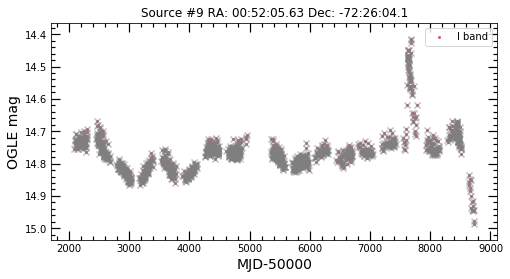

(0.25024931683430507, -0.17100000000000115)


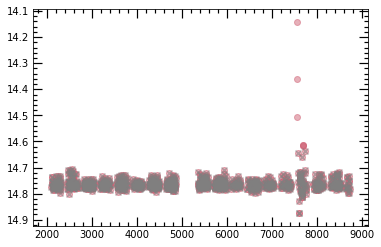

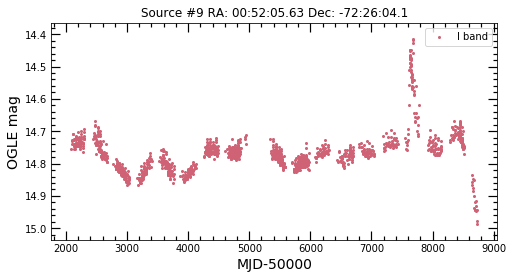

(0.22944594234554902, -0.17100000000000115)
original stdev: 0.07, detrended stdev: 0.03


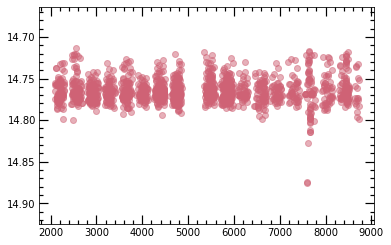

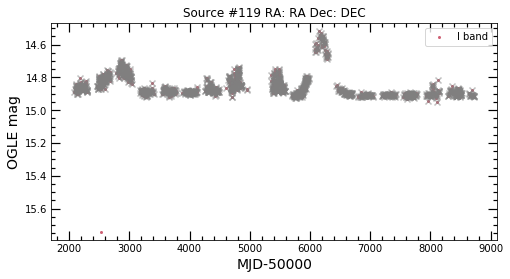

sigma-clipped original stdev: 0.07, sigma-clipped detrended stdev: 0.02
(0.3271832160541349, -0.28999999999999915)


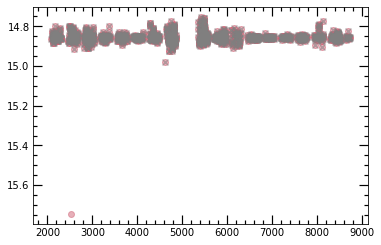

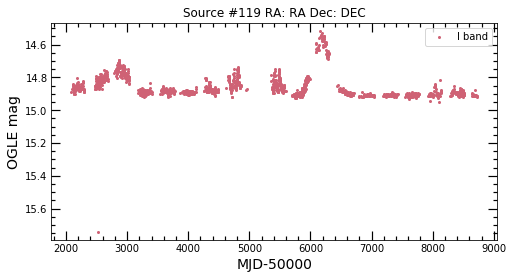

(0.43204928717780294, -0.27399999999999913)

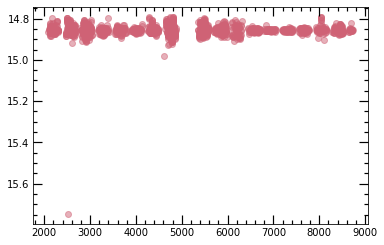

In [148]:
#good example of difference in extent of outliers between the two
print(new_type_axis_calc(9,plot=True,sigclip=True))
print(old_type_axis_calc(9,plot=True))
#example of getting rid of extreme outlier at both stages
print(new_type_axis_calc(119,plot=True,sigclip=True,printall=True))
old_type_axis_calc(119,plot=True)

In [85]:
#new calculations
bns,sratios = [np.nan],[np.nan] #nan for source #1
for s in summ['src_n'][1:]:
    try:
        sigratio,basenum = new_type_axis_calc(s,sigclip=True)
        sratios.append(sigratio)
        bns.append(basenum)
    except: sratios.append(np.nan); bns.append(np.nan)
        
summ['sig stdev ratio'] = sratios
summ['base num'] = bns 
# summ.to_csv('Feb23_summtab.csv',index=False)

empty file for OIII I
empty file for OII I
empty file for OIII I


In [23]:
def fulltplot(x='stdev I',y='det stdev I',legend=True,tbool=[False]*6,between=False,tab=alls):
    if between and len(tbool)==6: tbool.append(False) #make sure tbool is right length 
    o.tplot(type1,tab,color=pink,marker='*',label='1',x=x,y=y,text=tbool[0])
    o.tplot(type2,tab,color='black',label='2',x=x,y=y,text=tbool[1])
    o.tplot(type3,tab,marker='v',label='3',color='maroon',x=x,y=y,text=tbool[2])
    o.tplot(type4,tab,color='rebeccapurple',marker='P',label='4',x=x,y=y,text=tbool[3])
    o.tplot(type5,tab,marker='3',label='5',color='grey',x=x,y=y,text=tbool[4])
    o.tplot(type6,tab,color='darkseagreen',marker='h',label='6',x=x,y=y,text=tbool[5])
    #if between, also plot transition sources
    if between: o.tplot(typet,tab,marker='p',label='transition',color='navy',x=x,y=y,text=tbool[6])
    plt.ylabel(y,fontsize=14)
    plt.xlabel(x,fontsize=14)
    if legend: plt.legend()

In [27]:
#compare old types (which I generally want to preserve) to slightly changed version of calculation
#used to use alls as table argument but now summ works

type1 = o.gettype(summ,num='1')
type2 = o.gettype(summ,num='2')
type3 = o.gettype(summ,num='3')
type4 = o.gettype(summ,num='4')
type5 = o.gettype(summ,num='5')
type6 = o.gettype(summ,num='6')
#transition sources
typet = []
for i in range(len(summ)):
    row = summ.iloc[i]
    src = row['src_n']
    if '+' in str(row['type']):
        typet.append(int(src))

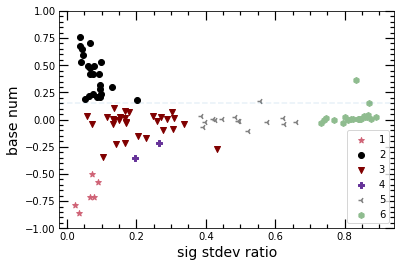

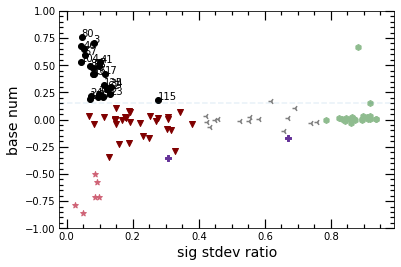

In [29]:
#comparison to (approx) old version of type definition (where 119 used to be type 5 but that's not shown here)
fulltplot(x='sig stdev ratio',y='base num',legend=True,tbool=[False,False,False,False,False,False])
plt.ylim(-1,1)
plt.axhline(.15,ls='dashed',alpha=0.1)
plt.show()
fulltplot(x='sig stdev ratio',y='base num',legend=False,tab=summ,tbool=[False,True,False,False,False,False])
plt.ylim(-1,1)
plt.axhline(.15,ls='dashed',alpha=0.1)
plt.show()

- only changing 119, which makes sense visually
- and then slightly less straightforward to group together 60 and 63 but worth it

# Type Definition

In [147]:
#option to integrate transition sources into other types and just discuss them

# for i in typet:
#     try:iband = o.getIV(i,cross,both=False,plot=True)
#     except:iband = o.getIV(i,cross2,mlist=mlist2,both=False,plot=True)

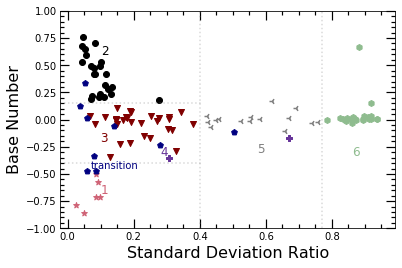

In [36]:
fulltplot(x='sig stdev ratio',y='base num',legend=False,tab=summ,between=True) #tbool=[False]*6+[True]
plt.ylim(-1,1)
plt.ylabel('Base Number',fontsize=16)
plt.xlabel('Standard Deviation Ratio',fontsize=16)

plt.axvline(0.77,color='grey',alpha=0.3,ls='dotted')
plt.axvline(0.4,color='grey',alpha=0.3,ls='dotted')
plt.axhline(-0.4,color='grey',alpha=0.3,ls='dotted',xmin=0,xmax=0.42)
plt.axhline(.15,color='grey',alpha=0.3,ls='dotted',xmin=0,xmax=0.42)
plt.text(0.1,-0.68,'1',color=pink,fontsize=12)
plt.text(0.1,0.6,'2',color='black',fontsize=12)
plt.text(0.1,-.2,'3',color='maroon',fontsize=12)
plt.text(0.28,-0.33,'4',color='rebeccapurple',fontsize=12)
plt.text(0.575,-0.3,'5',color='grey',fontsize=12)
plt.text(0.86,-0.33,'6',color='darkseagreen',fontsize=12)
plt.text(0.07,-0.45,'transition',color='navy',fontsize=10)

plt.savefig('TypeFigsMar23/type_definition.pdf',bbox_inches='tight')

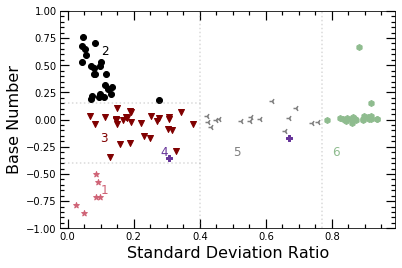

In [37]:
fulltplot(x='sig stdev ratio',y='base num',legend=False,tab=summ,between=False)
plt.ylim(-1,1)
plt.ylabel('Base Number',fontsize=16)
plt.xlabel('Standard Deviation Ratio',fontsize=16)

plt.axvline(0.77,color='grey',alpha=0.3,ls='dotted')
plt.axvline(0.4,color='grey',alpha=0.3,ls='dotted')
plt.axhline(-0.4,color='grey',alpha=0.3,ls='dotted',xmin=0,xmax=0.42)
plt.axhline(.15,color='grey',alpha=0.3,ls='dotted',xmin=0,xmax=0.42)
plt.text(0.1,-0.68,'1',color=pink,fontsize=12)
plt.text(0.1,0.6,'2',color='black',fontsize=12)
plt.text(0.1,-.2,'3',color='maroon',fontsize=12)
plt.text(0.28,-0.33,'4',color='rebeccapurple',fontsize=12)
plt.text(0.5,-0.33,'5',color='grey',fontsize=12)
plt.text(0.8,-0.33,'6',color='darkseagreen',fontsize=12)
# plt.text(0.07,-0.45,'transition',color='navy',fontsize=10)

plt.savefig('TypeFigsMar23/type_definition_without_transition.pdf',bbox_inches='tight')

# Examples

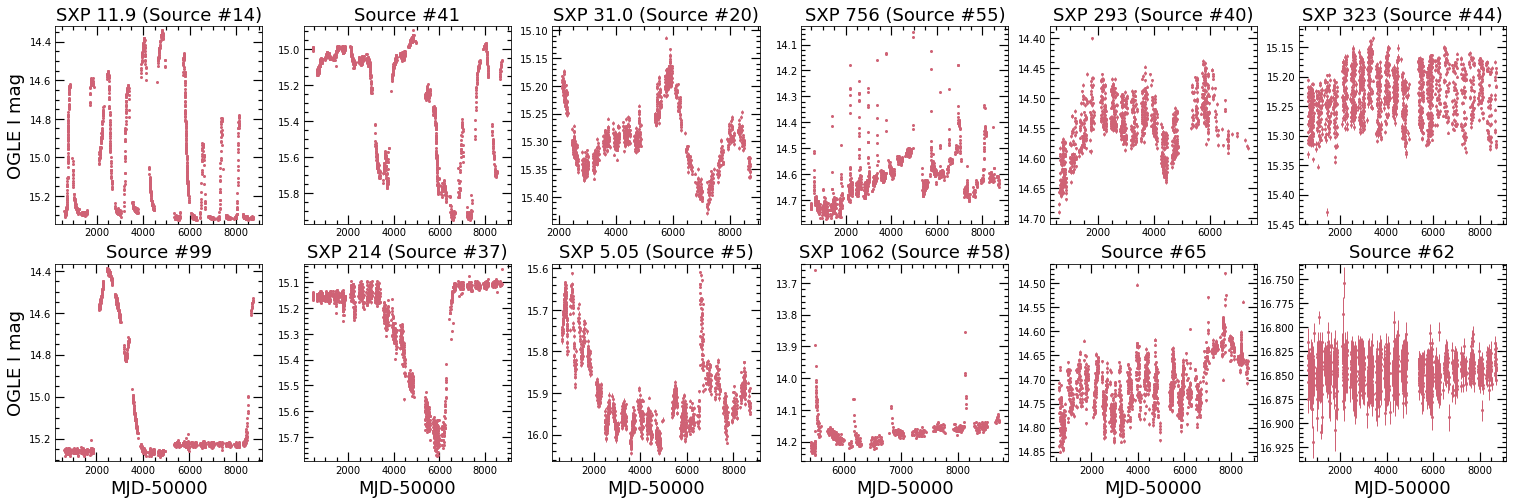

In [158]:
reps = [14,41,20,55,40,44,99,37,5,58,65,62]
fig = plt.figure(figsize=(26,8))
i = 1
for r in reps:
    ax = fig.add_subplot(2,6,i)
    old_num = reverse_src_dict[r]
    name = name_dict[old_num]
    if r in calibration_used:calib=True
    else: calib=False
    try:iband = o.getIV(old_num,cross,both=False,stack=True,plot=False,mlist=mlist1,figsize=(4,3),calib=calib)
    except:iband = o.getIV(old_num,cross2,both=False,stack=True,plot=False,mlist=mlist2,figsize=(4,3),calib=calib)
    ax.errorbar(iband['MJD-50000'],iband['I mag'],yerr=iband['I mag err'],elinewidth=1,ls='none',marker='o',markersize=2,color=pink,label=str((i)))
    mini,maxi = np.min(iband['I mag']),np.max(iband['I mag'])
    ax.set_ylim(maxi+.02,mini-.02)
    if len(str(name))>3:ax.set_title(f'{name} (Source #{r})',fontsize=18)
    else:ax.set_title(f'Source #{r}',fontsize=18)
    if i==7 or i==1:ax.set_ylabel('OGLE I mag',fontsize=18)
    if i>6:ax.set_xlabel('MJD-50000',fontsize=18)
    i+=1
plt.savefig('TypeFigsMar23/exampletypes.pdf',bbox_inches='tight')